In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
# Load signal sample into memory
with uproot.open("./ntuples/pufr_raw_ttbar/dataset_mu60_ztt1000_10k.root:fastjet") as f:
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_label_sig = ak.ones_like(jet_pt_sig)

# Load background sample into memory
with uproot.open("./ntuples/pufr_raw_ttbar/dataset_mu60_ttbar_10k.root:fastjet") as f:
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_label_bkg = ak.zeros_like(jet_pt_bkg)

In [3]:
class Jet:
    """
    The Jet object contains the features of each jet at the event level.
    It also has many useful methods to assist with data processing.
    """
    def __init__(self, feats):
        pt, eta, phi, m, label = feats
        self.pt = pt
        self.eta = eta
        self.phi = phi
        self.m = m
        self.label = label

    def __len__(self):
        return len(self.pt)
        
    def apply_mask(self, mask):
        self.pt = self.pt[mask]
        self.eta = self.eta[mask]
        self.phi = self.phi[mask]
        self.m = self.m[mask]
        self.label = self.label[mask]
        
    def return_event_idx(self):
        sig = (self.label==1)
        sig_event = ak.mean(sig,axis=1)==1
        bkg_event = ak.mean(sig,axis=1)==0
        return sig_event,bkg_event

    def return_mean(self):
        return [ak.mean(self.pt), ak.mean(self.eta), ak.mean(self.phi), ak.mean(self.m)]
    
    def return_std(self):
        return [ak.std(self.pt), ak.std(self.eta), ak.std(self.phi), ak.std(self.m)]
    
    def apply_norm(self,mean_list,std_list):
        self.pt = (self.pt-mean_list[0]) / std_list[0]
        self.eta = (self.eta-mean_list[1]) / std_list[1]
        self.phi = (self.phi-mean_list[2]) / std_list[2]
        self.m = (self.m-mean_list[3]) / std_list[3]
        
    def return_subset(self, start_idx, stop_idx):
        pt = self.pt[start_idx:stop_idx]
        eta = self.eta[start_idx:stop_idx]
        phi = self.phi[start_idx:stop_idx]
        m = self.m[start_idx:stop_idx]
        label = self.label[start_idx:stop_idx]
        feats = [pt,eta,phi,m,label]
        return Jet(feats)
    
    def return_dataset(self):
        data = ak.concatenate([self.pt[:,:,np.newaxis],self.eta[:,:,np.newaxis],self.phi[:,:,np.newaxis],self.m[:,:,np.newaxis]], axis=2)
        labels = ak.mean(self.label,axis=1)
        return data, labels

In [4]:
# Construct list of features
feats_sig = [jet_pt_sig, jet_eta_sig, jet_phi_sig, jet_m_sig, jet_label_sig]
feats_bkg = [jet_pt_bkg, jet_eta_bkg, jet_phi_bkg, jet_m_bkg, jet_label_bkg]

# Combined Signal and Background
feats = []
for i in range(len(feats_sig)):
    feats.append(ak.concatenate([feats_sig[i],feats_bkg[i]], axis=0))
    
# Initialize Jet object and pass features
jets = Jet(feats)

# Print features
print(jets.pt)
print(jets.eta)
print(jets.phi)
print(jets.m)
print(jets.label)

[[228, 172, 117, 98.6, 84.6, 47.1, ..., 26.7, 26.4, 25.8, 25.8, 25.5], ...]
[[-1.18, 1.31, 0.943, -1.1, 0.682, ..., -2.4, 3.03, -3.3, 1.94, 1.83], ...]
[[2.05, 4.71, 5.34, 1.46, 6.11, 3.81, ..., 2.23, 1.86, 4.27, 5.31, 0.443], ...]
[[50.4, 35.5, 31.4, 27.7, 22.9, 27.7, ..., 14.6, 14.4, 10.3, 14.7, 14.4], ...]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], ...]


In [5]:
# Shuffle the events
shuffled_idx = np.random.permutation(len(jets))
jets.apply_mask(shuffled_idx)

In [6]:
# Plot number of jets per event
h_num_jets = ak.num(jets.pt,axis=1)
sig,bkg = jets.return_event_idx()
#plt.title('Num Jets per Event')
#plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=30,range=(0,ak.max(h_num_jets)))
#plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=30,range=(0,ak.max(h_num_jets)))
#plt.xlabel('Num Jets',loc='right')
#plt.legend()
#plt.show()

# Require at least six jets
mask = h_num_jets>=6
jets.apply_mask(mask)
h_num_jets = ak.num(jets.pt,axis=1)
sig,bkg = jets.return_event_idx()
#plt.title('Num Jets per Event (Require 6 Jets)')
#plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=30,range=(0,ak.max(h_num_jets)))
#plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=30,range=(0,ak.max(h_num_jets)))
#plt.xlabel('Num Jets',loc='right')
#plt.legend()
#plt.show()

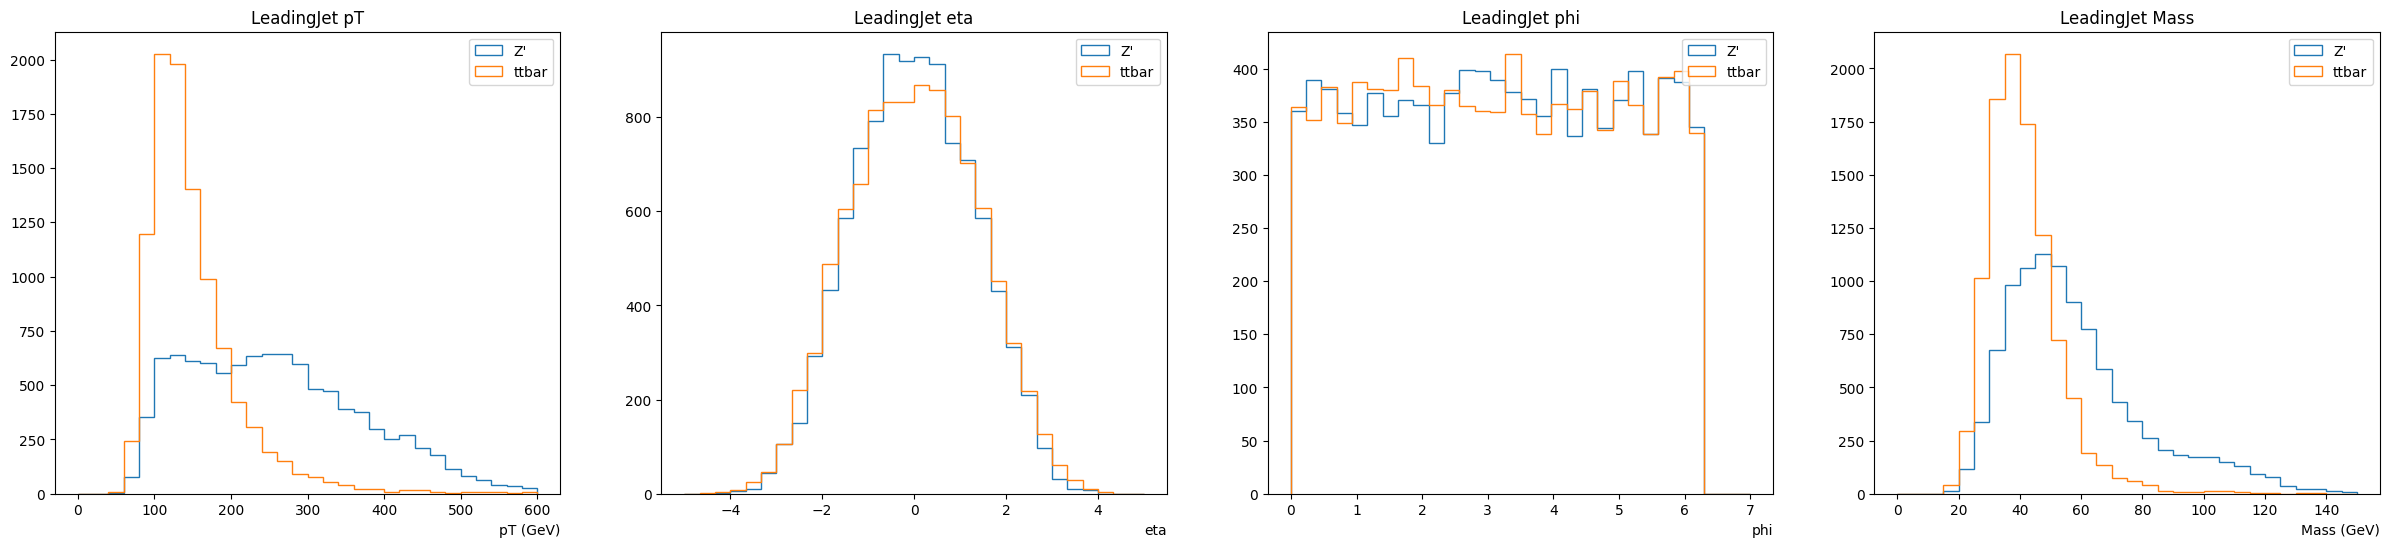

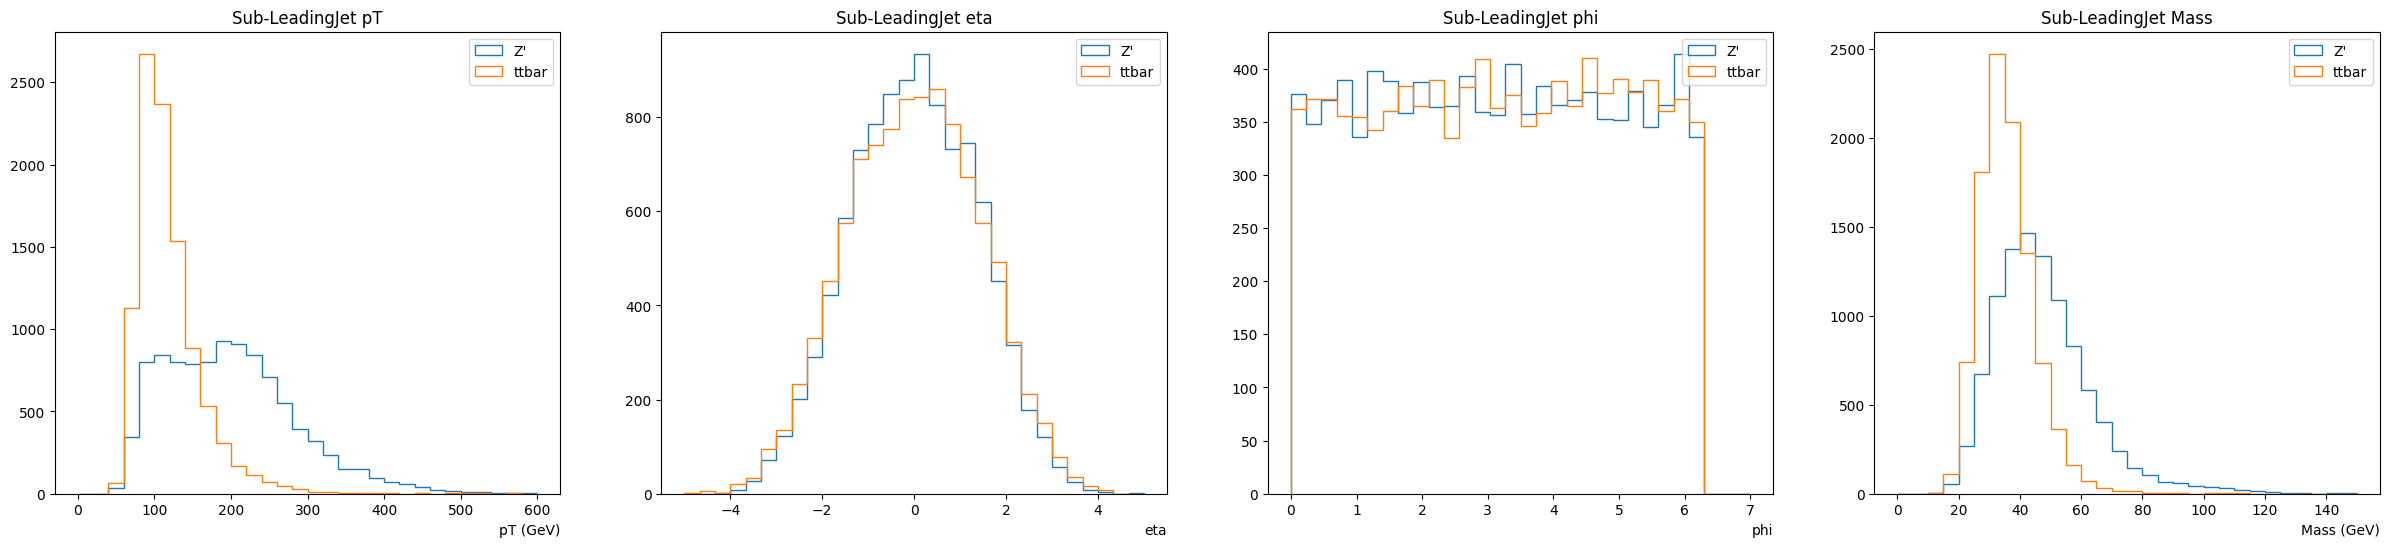

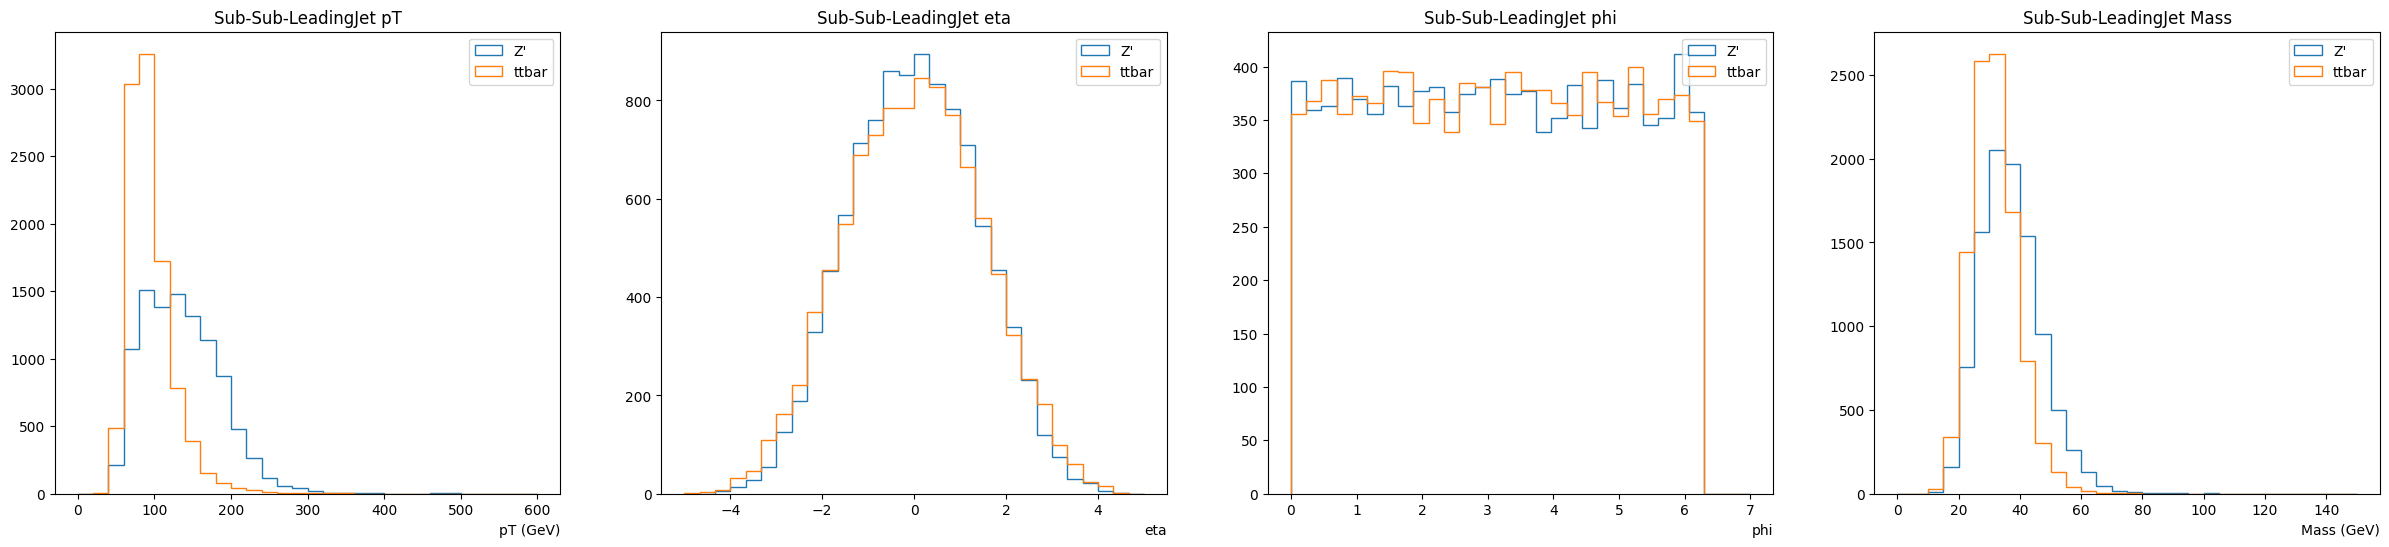

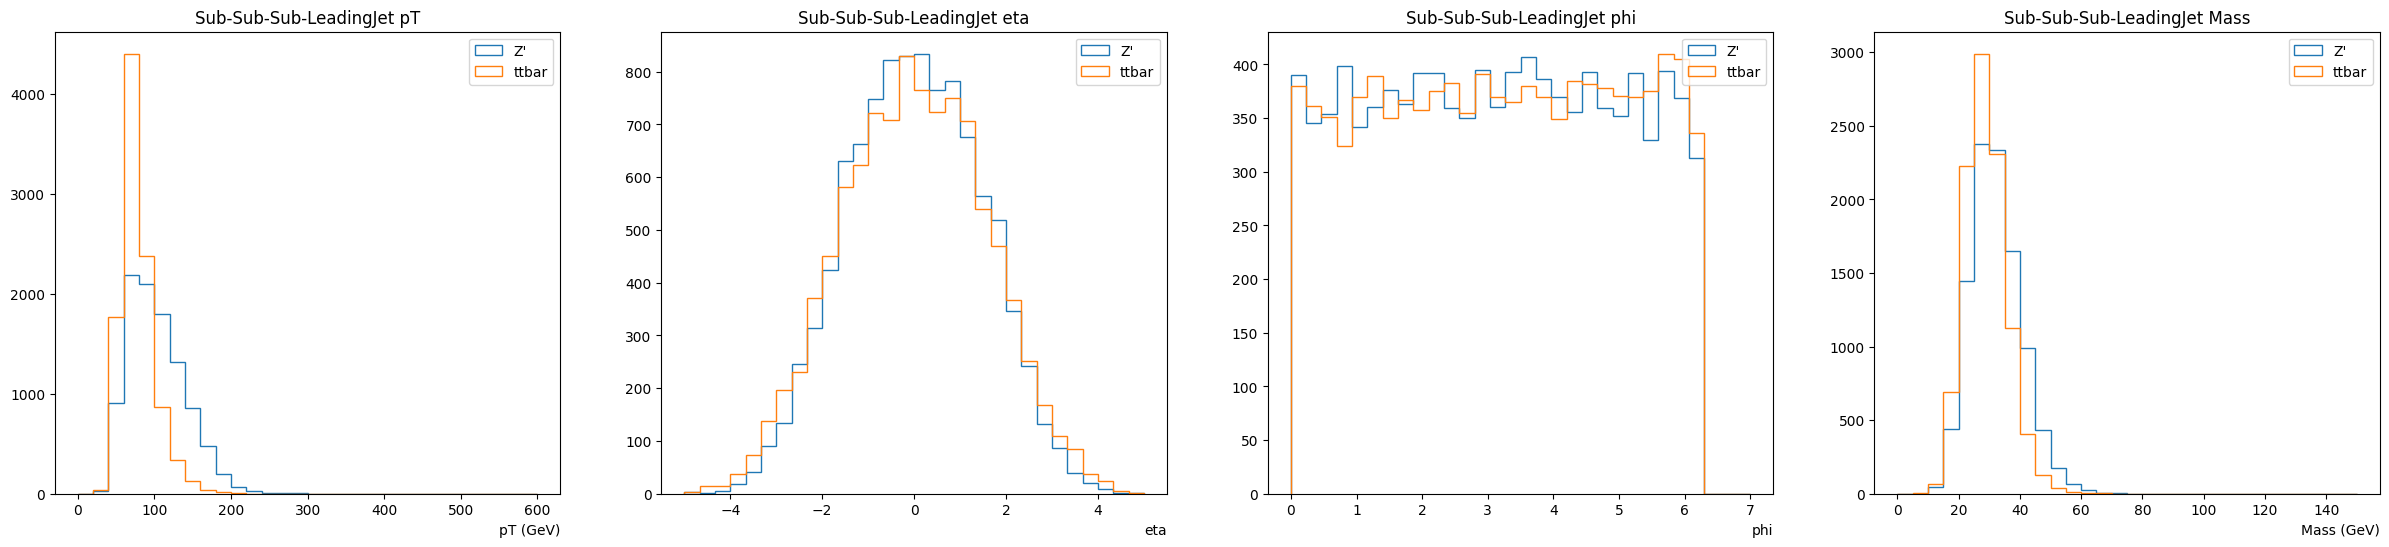

In [7]:
sig,bkg = jets.return_event_idx()

var_list = ['Leading','Sub-Leading','Sub-Sub-Leading','Sub-Sub-Sub-Leading']

for i, name in enumerate(var_list):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 6))

    ax1.set_title(name+'Jet pT')
    ax1.hist(jets.pt[:,i][sig],histtype='step',label='Z\'',bins=30,range=(0,600))
    ax1.hist(jets.pt[:,i][bkg],histtype='step',label='ttbar',bins=30,range=(0,600))
    ax1.set_xlabel('pT (GeV)',loc='right')
    ax1.legend(loc='upper right')

    ax2.set_title(name+'Jet eta')
    ax2.hist(jets.eta[:,i][sig],histtype='step',label='Z\'',bins=30,range=(-5,5))
    ax2.hist(jets.eta[:,i][bkg],histtype='step',label='ttbar',bins=30,range=(-5,5))
    ax2.set_xlabel('eta',loc='right')
    ax2.legend(loc='upper right')


    ax3.set_title(name+'Jet phi')
    ax3.hist(jets.phi[:,i][sig],histtype='step',label='Z\'',bins=30,range=(0,7))
    ax3.hist(jets.phi[:,i][bkg],histtype='step',label='ttbar',bins=30,range=(0,7))
    ax3.set_xlabel('phi',loc='right')
    ax3.legend(loc='upper right')

    ax4.set_title(name+'Jet Mass')
    ax4.hist(jets.m[:,i][sig],histtype='step',label='Z\'',bins=30,range=(0,150))
    ax4.hist(jets.m[:,i][bkg],histtype='step',label='ttbar',bins=30,range=(0,150))
    ax4.set_xlabel('Mass (GeV)',loc='right')
    ax4.legend(loc='upper right')
    plt.show()

In [8]:
def test_val_train_split(Jets):
    num_events = len(Jets)
    train_split = int(0.7*num_events)
    test_split = int(0.75*num_events)
    
    X_train = Jets.return_subset(0,train_split)
    X_val = Jets.return_subset(train_split,test_split)
    X_test = Jets.return_subset(test_split,num_events)
    
    mean_list = X_train.return_mean()
    std_list = X_train.return_std()
    
    X_train.apply_norm(mean_list, std_list)
    X_val.apply_norm(mean_list, std_list)
    X_test.apply_norm(mean_list, std_list)
    
    X_train, y_train = X_train.return_dataset()
    X_val, y_val = X_val.return_dataset()
    X_test, y_test = X_test.return_dataset()
    
    return X_train, y_train, X_val, y_val, X_test, y_test
    
X_train, y_train, X_val, y_val, X_test, y_test = test_val_train_split(jets)

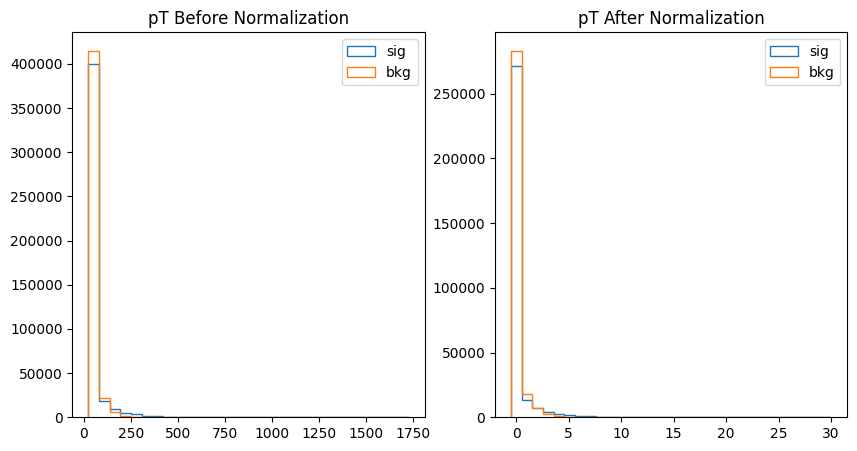

Before Mean:  44.964223633892736
Before STD:  42.64035764175273
After Mean:  -0.00022784760556022294
After STD:  1.000200141816903


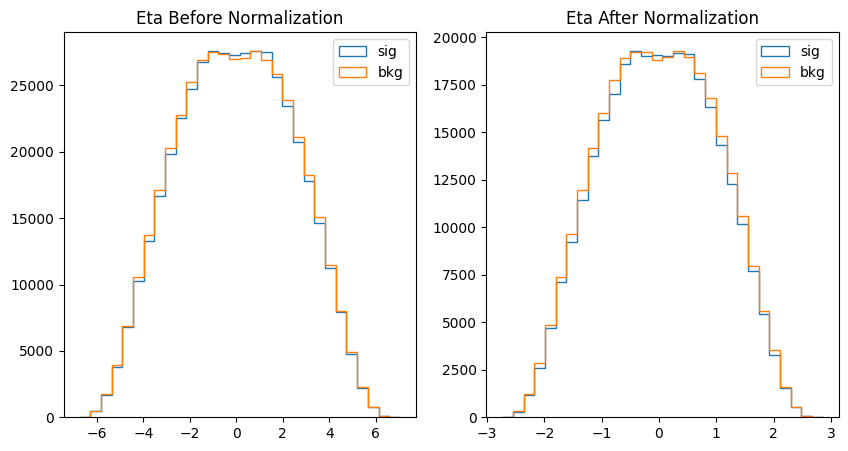

Before Mean:  -0.0012790590526422685
Before STD:  2.4667152087693105
After Mean:  4.619878576821174e-09
After STD:  1.000092505480777


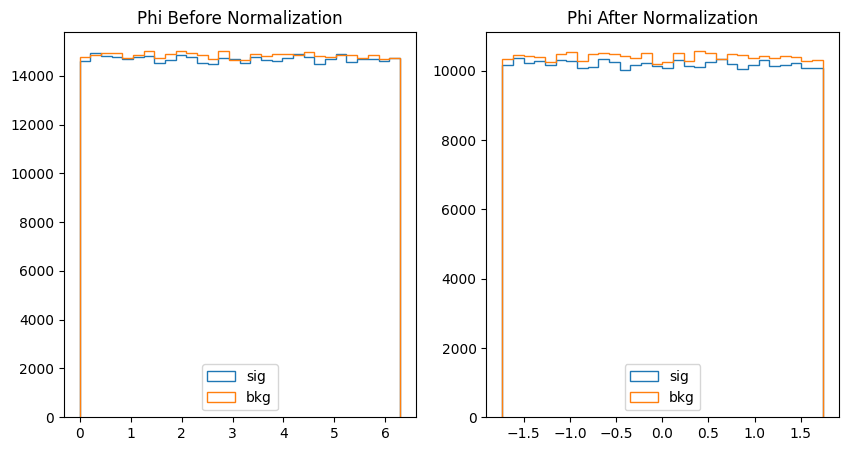

Before Mean:  3.138314833376225
Before STD:  1.812950138042578
After Mean:  3.4762111109573294e-05
After STD:  1.0002351031541317


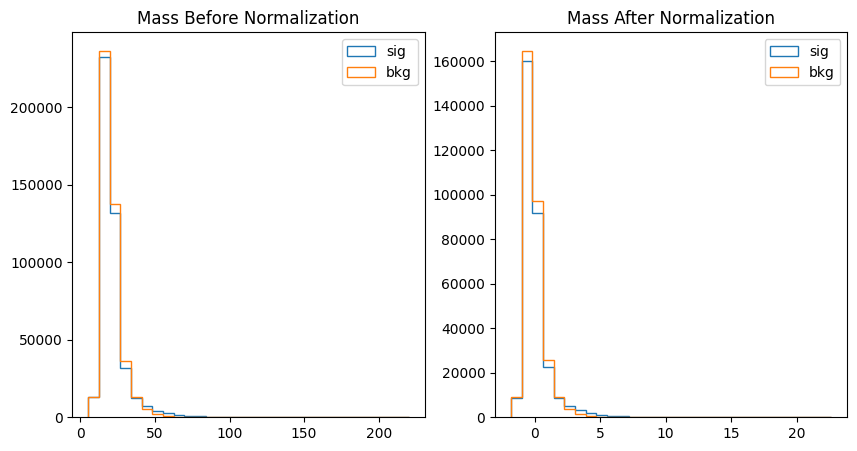

Before Mean:  20.958803451218355
Before STD:  8.73324919881126
After Mean:  2.9543808741143307e-06
After STD:  1.0000199014584794


In [9]:
# Validation plots
var_list = ['pT','Eta','Phi','Mass']
var_list_before = [jets.pt,jets.eta,jets.phi,jets.m]
var_list_after = [X_train[:,:,0],X_train[:,:,1],X_train[:,:,2],X_train[:,:,3]]

for i in range(4):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    var1 = var_list_before[i]
    mini=ak.min(var1)
    maxi=ak.max(var1)
    sig,bkg = jets.return_event_idx()
    ax1.hist(ak.ravel(var1[sig]),histtype='step',label='sig',bins=30,range=(mini,maxi))
    ax1.hist(ak.ravel(var1[bkg]),histtype='step',label='bkg',bins=30,range=(mini,maxi))
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    var2 = var_list_after[i]
    mini=ak.min(var2)
    maxi=ak.max(var2)
    sig = (y_train==1)
    bkg = ~sig
    ax2.hist(ak.ravel(var2[sig]),histtype='step',label='sig',bins=30,range=(mini,maxi))
    ax2.hist(ak.ravel(var2[bkg]),histtype='step',label='bkg',bins=30,range=(mini,maxi))
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    plt.show()
    print("Before Mean: ", np.mean(var1))
    print("Before STD: ", np.std(var1))
    print("After Mean: ", np.mean(var2))
    print("After STD: ", np.std(var2))

In [10]:
Leading = X_train[:,0:1,:]
N_Leading = X_train[:,0:2,:]
NN_Leading = X_train[:,0:3,:]
NNN_Leading = X_train[:,0:4,:]

In [11]:
# Convert to torch.Tensor()
All_Jets_train = torch.nested.nested_tensor(ak.to_list(X_train))
Leading_train = torch.nested.nested_tensor(ak.to_list(X_train[:,0:1,:]))
#N_Leading_train = torch.nested.nested_tensor(ak.to_list(X_train[:,0:2,:]))
#NN_Leading_train = torch.nested.nested_tensor(ak.to_list(X_train[:,0:3,:]))
NNN_Leading_train = torch.nested.nested_tensor(ak.to_list(X_train[:,0:6,:]))
y_train = torch.Tensor(y_train).reshape(-1,1)

All_Jets_val = torch.nested.nested_tensor(ak.to_list(X_val))
Leading_val = torch.nested.nested_tensor(ak.to_list(X_val[:,0:1,:]))
#N_Leading_val = torch.nested.nested_tensor(ak.to_list(X_val[:,0:2,:]))
#NN_Leading_val = torch.nested.nested_tensor(ak.to_list(X_val[:,0:3,:]))
NNN_Leading_val = torch.nested.nested_tensor(ak.to_list(X_val[:,0:6,:]))
y_val = torch.Tensor(y_val).reshape(-1,1)

All_Jets_test = torch.nested.nested_tensor(ak.to_list(X_test))
Leading_test = torch.nested.nested_tensor(ak.to_list(X_test[:,0:1,:]))
#N_Leading_test = torch.nested.nested_tensor(ak.to_list(X_test[:,0:2,:]))
#NN_Leading_test = torch.nested.nested_tensor(ak.to_list(X_test[:,0:3,:]))
NNN_Leading_test = torch.nested.nested_tensor(ak.to_list(X_test[:,0:6,:]))
y_test = torch.Tensor(y_test).reshape(-1,1)

/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [12]:
class Model(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Model, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.jet_postprocess = nn.Linear(hidden_feats,hidden_feats)
        self.attention = nn.MultiheadAttention(hidden_feats,num_heads=16,batch_first=True, dropout=0.25)
        self.jet_classifier = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        # Preprocess Jet Feats
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))
        
        # Attention Layer + Skip Connection + Post-Process
        jet_attention, jet_weights = self.attention(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding = jet_embedding + jet_attention
        jet_embedding = F.gelu(self.jet_postprocess(jet_embedding))

        # Aggregate and Classify
        jet_aggregated = jet_embedding.sum(dim=0)
        output = F.sigmoid(self.jet_classifier(jet_aggregated))
        return output

In [13]:
def train(model, data, epochs=20):
    X_train, y_train, X_val, y_val = data
    
    history = {'train_loss':[],'test_loss':[]}
   
    for e in range(epochs):     
        cum_loss_train = []
        cum_loss_val = []
        num_train = X_train.size(0)
        model.train()
        for event in range(num_train):
            optimizer.zero_grad()
            output = model(X_train[event].to(device))
            loss = loss_fn(output, y_train[event].to(device))
            loss.backward()
            optimizer.step()
            cum_loss_train.append(loss.detach().cpu().numpy())
        
        num_val = X_val.size(0)
        model.eval()
        for event in range(num_val):
            y_pred = model(X_val[event].to(device))
            loss = loss_fn(y_pred,y_val[event].to(device))
            cum_loss_val.append(loss.detach().cpu().numpy())

        history['train_loss'].append(np.mean(cum_loss_train))
        history['test_loss'].append(np.mean(cum_loss_val))

        if (e+1)%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(np.mean(cum_loss_train)),4),'\tVal Loss:',round(float(np.mean(cum_loss_val)),4))

    return history

In [14]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [15]:
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.BCELoss()

Epochs = 70

# Train model with pt,eta,phi,m
print("Training All Jets")
All_Jets = Model(4,16,1).to(device)
optimizer = optim.Adam(All_Jets.parameters(), lr=0.0001)
data = [All_Jets_train, y_train, All_Jets_val, y_val]
All_Jets_history = train(All_Jets, data, epochs=Epochs)
print()

# Train model with pt,eta,phi,m
print("Training Leading Jet")
Leading_Jet = Model(4,16,1).to(device)
optimizer = optim.Adam(Leading_Jet.parameters(), lr=0.0001)
data = [Leading_train, y_train, Leading_val, y_val]
Leading_Jet_history = train(Leading_Jet, data, epochs=Epochs)
print()

# Train model with pt,eta,phi,m
#print("Training N Leading Jet")
#N_Leading_Jet = Model(4,16,1).to(device)
#optimizer = optim.Adam(N_Leading_Jet.parameters(), lr=0.0001)
#data = [N_Leading_train, y_train, N_Leading_val, y_val]
#N_Leading_Jet_history = train(N_Leading_Jet, data, epochs=Epochs)
#print()

# Train model with pt,eta,phi,m
#print("Training NN Leading Jet")
#NN_Leading_Jet = Model(4,16,1).to(device)
#optimizer = optim.Adam(NN_Leading_Jet.parameters(), lr=0.0001)
#data = [NN_Leading_train, y_train, NN_Leading_val, y_val]
#NN_Leading_Jet_history = train(NN_Leading_Jet, data, epochs=Epochs)
#print()

# Train model with pt,eta,phi,m
print("Training NNN Leading Jet")
NNN_Leading_Jet = Model(4,16,1).to(device)
optimizer = optim.Adam(NNN_Leading_Jet.parameters(), lr=0.0001)
data = [NNN_Leading_train, y_train, NNN_Leading_val, y_val]
NNN_Leading_Jet_history = train(NNN_Leading_Jet, data, epochs=Epochs)
print()

Training All Jets
Epoch: 1 	Train Loss: 0.5714 	Val Loss: 0.5893
Epoch: 2 	Train Loss: 0.5361 	Val Loss: 0.5649
Epoch: 3 	Train Loss: 0.5304 	Val Loss: 0.5594
Epoch: 4 	Train Loss: 0.5271 	Val Loss: 0.5564
Epoch: 5 	Train Loss: 0.525 	Val Loss: 0.5544
Epoch: 6 	Train Loss: 0.5234 	Val Loss: 0.5502
Epoch: 7 	Train Loss: 0.5218 	Val Loss: 0.5489
Epoch: 8 	Train Loss: 0.5207 	Val Loss: 0.5482
Epoch: 9 	Train Loss: 0.5194 	Val Loss: 0.5459
Epoch: 10 	Train Loss: 0.5188 	Val Loss: 0.5444
Epoch: 11 	Train Loss: 0.518 	Val Loss: 0.5446
Epoch: 12 	Train Loss: 0.5175 	Val Loss: 0.5433
Epoch: 13 	Train Loss: 0.517 	Val Loss: 0.542
Epoch: 14 	Train Loss: 0.517 	Val Loss: 0.5426
Epoch: 15 	Train Loss: 0.5159 	Val Loss: 0.5401
Epoch: 16 	Train Loss: 0.5156 	Val Loss: 0.5417
Epoch: 17 	Train Loss: 0.515 	Val Loss: 0.539
Epoch: 18 	Train Loss: 0.5151 	Val Loss: 0.5393
Epoch: 19 	Train Loss: 0.5151 	Val Loss: 0.5387
Epoch: 20 	Train Loss: 0.5146 	Val Loss: 0.5386
Epoch: 21 	Train Loss: 0.5146 	Val Los

Epoch: 32 	Train Loss: 0.5041 	Val Loss: 0.5373
Epoch: 33 	Train Loss: 0.5037 	Val Loss: 0.5371
Epoch: 34 	Train Loss: 0.5031 	Val Loss: 0.5364
Epoch: 35 	Train Loss: 0.5028 	Val Loss: 0.5368
Epoch: 36 	Train Loss: 0.5028 	Val Loss: 0.5367
Epoch: 37 	Train Loss: 0.5029 	Val Loss: 0.5366
Epoch: 38 	Train Loss: 0.5023 	Val Loss: 0.5367
Epoch: 39 	Train Loss: 0.5022 	Val Loss: 0.5364
Epoch: 40 	Train Loss: 0.501 	Val Loss: 0.5373
Epoch: 41 	Train Loss: 0.5009 	Val Loss: 0.5367
Epoch: 42 	Train Loss: 0.5008 	Val Loss: 0.5363
Epoch: 43 	Train Loss: 0.5 	Val Loss: 0.5364
Epoch: 44 	Train Loss: 0.5003 	Val Loss: 0.5365
Epoch: 45 	Train Loss: 0.4999 	Val Loss: 0.5351
Epoch: 46 	Train Loss: 0.4985 	Val Loss: 0.5358
Epoch: 47 	Train Loss: 0.4992 	Val Loss: 0.5361
Epoch: 48 	Train Loss: 0.4993 	Val Loss: 0.5361
Epoch: 49 	Train Loss: 0.4988 	Val Loss: 0.5352
Epoch: 50 	Train Loss: 0.4983 	Val Loss: 0.5365
Epoch: 51 	Train Loss: 0.4982 	Val Loss: 0.5373
Epoch: 52 	Train Loss: 0.4977 	Val Loss: 0.5

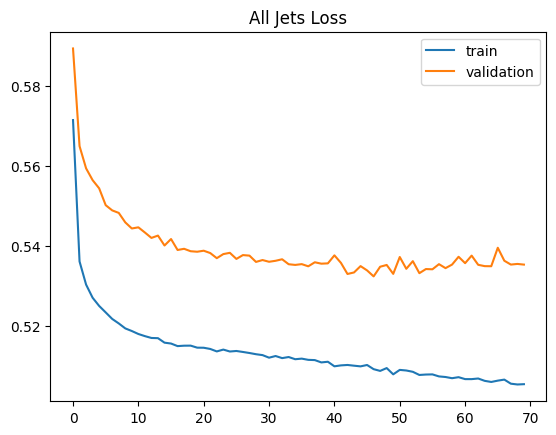

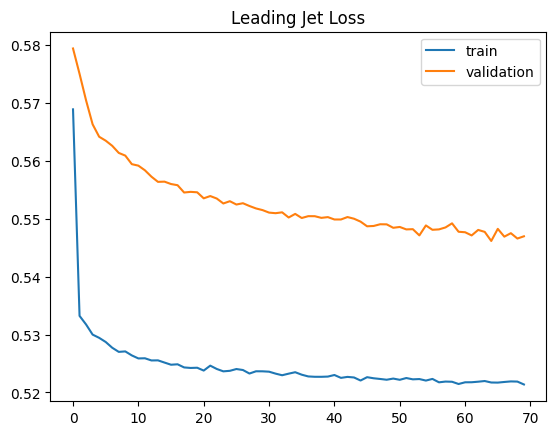

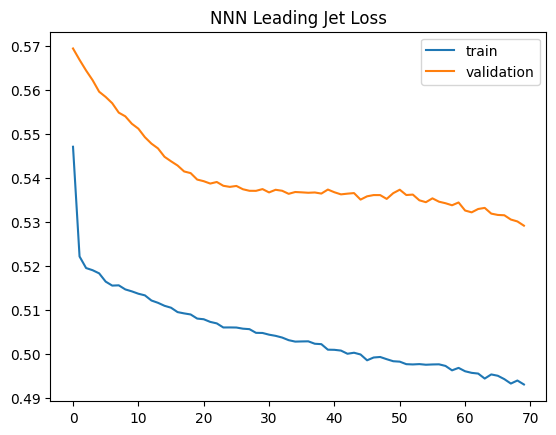

In [16]:
plt.plot(All_Jets_history['train_loss'],label='train')
plt.plot(All_Jets_history['test_loss'],label='validation')
plt.title("All Jets Loss")
plt.legend()
plt.show()

plt.plot(Leading_Jet_history['train_loss'],label='train')
plt.plot(Leading_Jet_history['test_loss'],label='validation')
plt.title("Leading Jet Loss")
plt.legend()
plt.show()

#plt.plot(N_Leading_Jet_history['train_loss'],label='train')
#plt.plot(N_Leading_Jet_history['test_loss'],label='validation')
#plt.title("N Leading Jet Loss")
#plt.legend()
#plt.show()

#plt.plot(NN_Leading_Jet_history['train_loss'],label='train')
#plt.plot(NN_Leading_Jet_history['test_loss'],label='validation')
#plt.title("NN Leading Jet Loss")
#plt.legend()
#plt.show()

plt.plot(NNN_Leading_Jet_history['train_loss'],label='train')
plt.plot(NNN_Leading_Jet_history['test_loss'],label='validation')
plt.title("NNN Leading Jet Loss")
plt.legend()
plt.show()

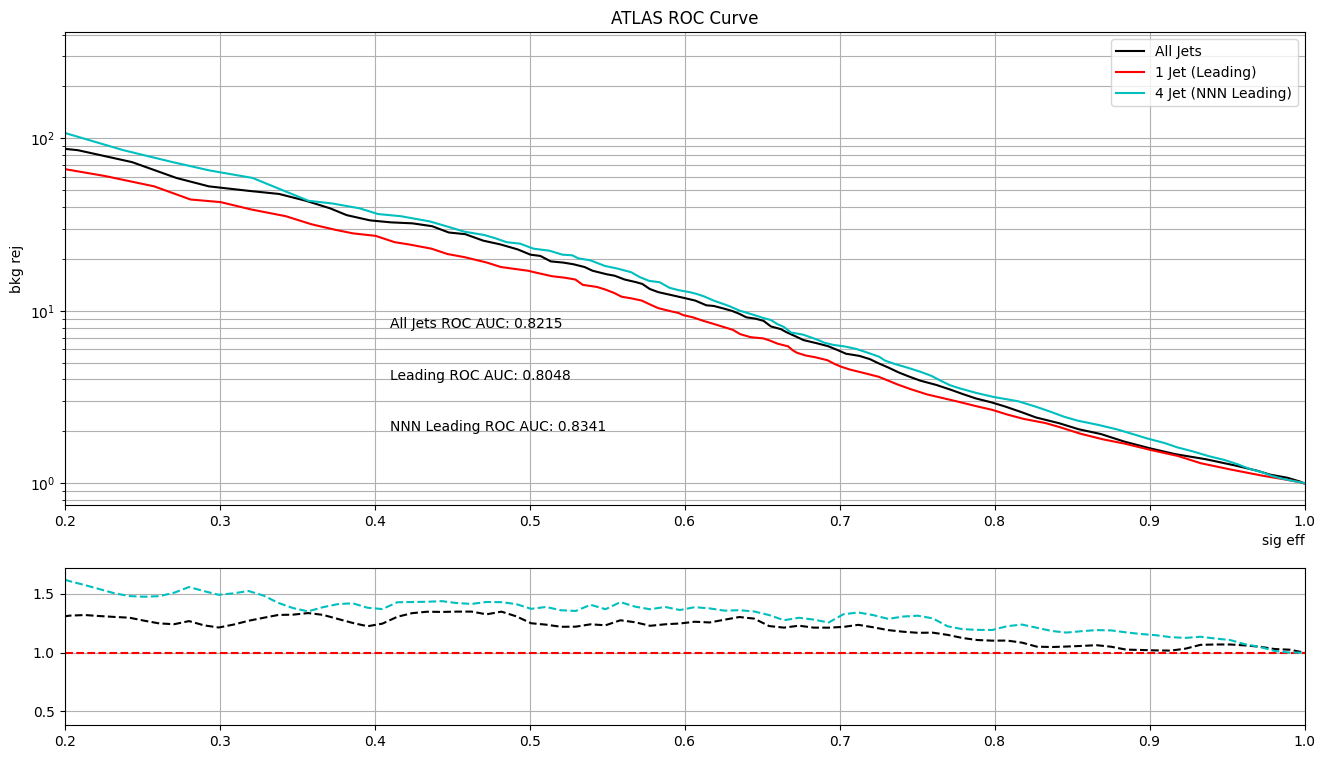

All Jets	 Binary Accuracy:  0.7663065226090436 	F1 Score:  0.7405597512216793

Leading Jet	 Binary Accuracy:  0.7519007603041217 	F1 Score:  0.7255422753430721

NNN Leading Jet	 Binary Accuracy:  0.767907162865146 	F1 Score:  0.7433628318584071


In [19]:
def ATLAS_roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    bkg_eff = []
    
    thresholds = np.linspace(0,0.95,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(1-((y_pred[bkg] < threshold).sum()  / y_true[bkg].shape[0]))

        #print("Theshold: ", threshold)
        #print("Signal Efficiency: ", sig_eff[-1])
        #print("Background Efficiency: ", bkg_eff[-1],"\n")
        
    bkg_rej = [1/x for x in bkg_eff]
    return np.array(sig_eff), np.array(bkg_rej), thresholds

def get_predictions(model, data):
    X_test, y_test = data
    model.to(device)
    model.eval()
    
    label_pred = []

    num_test = X_test.size(0)
    for event in range(num_test):
        l_pred = model(X_test[event].to(device))
        label_pred.append(l_pred.detach().cpu().numpy())
    label_pred = np.array(label_pred)
    return label_pred

def get_metrics(y_true, y_pred, threshold):
    y_Pred = y_pred > threshold
    x,y, thresholds = ATLAS_roc(y_true, y_pred)
    AUC = roc_auc_score(y_true, y_pred)
    BA = accuracy_score(y_true, y_Pred)
    f1 = f1_score(y_true, y_Pred)
    return x,y,thresholds,AUC,BA,f1

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]})

all_pred = get_predictions(All_Jets, [All_Jets_test, y_test])
leading_pred = get_predictions(Leading_Jet, [Leading_test, y_test])
#N_leading_pred = get_predictions(N_Leading_Jet, [N_Leading_test, y_test])
#NN_leading_pred = get_predictions(NN_Leading_Jet, [NN_Leading_test, y_test])
NNN_leading_pred = get_predictions(NNN_Leading_Jet, [NNN_Leading_test, y_test])

x1,y1,th1,AUC1,BA1,f11 = get_metrics(y_test, all_pred, 0.5)
x2,y2,th2,AUC2,BA2,f12 = get_metrics(y_test, leading_pred, 0.5)
#x3,y3,th3,AUC3,BA3,f13 = get_metrics(y_test, N_leading_pred, 0.5)
#x4,y4,th4,AUC4,BA4,f14 = get_metrics(y_test, NN_leading_pred, 0.5)
x5,y5,th5,AUC5,BA5,f15 = get_metrics(y_test, NNN_leading_pred, 0.5)


ax1.set_title("ATLAS ROC Curve")
ax1.set_xlabel("sig eff",loc='right')
ax1.set_ylabel("bkg rej")

ax1.plot(x1,y1, label="All Jets",color='k')
AUC1 = "All Jets ROC AUC: " + str(round(AUC1,4))
ax1.text(0.41,8,AUC1)

ax1.plot(x2,y2, label="1 Jet (Leading)",color='r')
AUC2 = "Leading ROC AUC: " + str(round(AUC2,4))
ax1.text(0.41,4,AUC2)

#ax1.plot(x3,y3, label="2 Jet (N Leading)",color='g')
#AUC3 = "N Leading ROC AUC: " + str(round(AUC3,4))
#ax1.text(0.51,1.6,AUC3)

#ax1.plot(x4,y4, label="3 Jet (NN Leading)",color='b')
#AUC4 = "NN Leading ROC AUC: " + str(round(AUC4,4))
#ax1.text(0.51,1.4,AUC4)

ax1.plot(x5,y5, label="4 Jet (NNN Leading)",color='c')
AUC5 = "NNN Leading ROC AUC: " + str(round(AUC5,4))
ax1.text(0.41,2,AUC5)

# Plot ratio plot
x = 1-np.flip(th1)
ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x2),np.flip(y2))
ratio2 = np.interp(x,np.flip(x2),np.flip(y2))/np.interp(x,np.flip(x2),np.flip(y2))
#ratio3 = np.interp(x,np.flip(x3),np.flip(y3))/np.interp(x,np.flip(x2),np.flip(y2))
#ratio4 = np.interp(x,np.flip(x4),np.flip(y4))/np.interp(x,np.flip(x2),np.flip(y2))
ratio5 = np.interp(x,np.flip(x5),np.flip(y5))/np.interp(x,np.flip(x2),np.flip(y2))

ax2.plot(x,ratio1,linestyle='--',color='k')
ax2.plot(x,ratio2,linestyle='--',color='r')
#ax2.plot(x,ratio3,linestyle='--',color='g')
#ax2.plot(x,ratio4,linestyle='--',color='b')
ax2.plot(x,ratio5,linestyle='--',color='c')

# General Plot Settings
ax1.legend()
ax1.set_yscale('log')
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_xlim(0.2,1)
ax2.set_xlim(0.2,1)
plt.show()

print("All Jets\t","Binary Accuracy: ", BA1, "\tF1 Score: ", f11)
print("")
print("Leading Jet\t","Binary Accuracy: ", BA2, "\tF1 Score: ", f12)
print("")
#print("N Leading Jets\t","Binary Accuracy: ", BA3, "\tF1 Score: ", f13)
#print("")
#print("NN Leading Jets\t","Binary Accuracy: ", BA4, "\tF1 Score: ", f14)
#print("")
print("NNN Leading Jet\t","Binary Accuracy: ", BA5, "\tF1 Score: ", f15)